# Compiling the building footprints of Electrical substations (onderstations)

The objective of this notebook is to compile a data set consisting of electrical substation footprints as a supporting solution for lvc reconstructor and path-finder problem.

In [21]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pyproj
import osmnx  as ox
import tqdm
from shapely.ops import unary_union
import matplotlib.pyplot as plt

In [2]:
CRS = 4326

stations = gpd.read_parquet('../../data/atom/stations.parquet')
stations = stations.to_crs(pyproj.CRS.from_epsg(CRS))
stations.head()

,id,station,netbeheerder,status,totaleCapaciteitInvoedingMva,totaleCapaciteitAfnameMva,beschikbareCapaciteitInvoedingHuidigMva,beschikbareCapaciteitAfnameHuidigMva,verwachtJaarVanOverbelastingInvoeding,verwachtJaarVanOverbelastingAfname,...,peildatum,beschikbareCapaciteitAfname3JaarMvaVisualisatie,beschikbareCapaciteitAfname5JaarMvaVisualisatie,beschikbareCapaciteitAfname10JaarMvaVisualisatie,beschikbareCapaciteitAfnameHuidigMvaVisualisatie,beschikbareCapaciteitInvoeding3JaarMvaVisualisatie,beschikbareCapaciteitInvoeding5JaarMvaVisualisatie,beschikbareCapaciteitInvoeding10JaarMvaVisualisatie,beschikbareCapaciteitInvoedingHuidigMvaVisualisatie,geometry
0,stations.34bda653-e4ae-4a3b-9399-c59f9f730745,Krimpen_Langeland 50 kV,Stedin,Bestaand,117.0,117.0,142.0,12.0,2050,2026,...,2022-10-18,0,0,0,12,0,0,0,142,POINT (4.62915 51.91080)
1,stations.b3b5f7d2-8fb9-4b44-9fe8-cdecd171eceb,Rotterdam Ommoord 25 kV,Stedin,Bestaand,115.0,115.0,157.0,-30.0,2050,2050,...,2022-10-18,0,0,0,0,149,148,142,157,POINT (4.52947 51.95541)
2,stations.57fc548f-9089-4e24-ab62-7555f0035b4b,Gouda Ijsseldijk 50 kV,Stedin,Bestaand,200.0,200.0,185.0,48.0,2045,2035,...,2022-10-18,22,13,0,48,203,176,121,185,POINT (4.73411 52.00775)
3,stations.600e067d-26f2-4f1a-944b-54d47534ba72,Delft 1 25 kV,Stedin,Bestaand,187.0,187.0,205.0,46.0,2050,2027,...,2022-10-18,15,4,0,46,201,191,160,205,POINT (4.36754 51.98904)
4,stations.5c7d27cc-871e-4c39-aa64-2186cb674d25,Grindweg 25 kV,Stedin,Bestaand,40.0,40.0,48.0,5.0,2050,2026,...,2022-10-18,3,0,0,5,38,36,30,48,POINT (4.49639 51.96228)


In [3]:
verzorgingsgebied = gpd.read_parquet('../../data/atom/verzorgingsgebied.parquet')
verzorgingsgebied = verzorgingsgebied.to_crs(CRS)
verzorgingsgebied.head()

,id,station,netbeheerder,status,totaleCapaciteitInvoedingMva,totaleCapaciteitAfnameMva,beschikbareCapaciteitInvoedingHuidigMva,beschikbareCapaciteitAfnameHuidigMva,verwachtJaarVanOverbelastingInvoeding,verwachtJaarVanOverbelastingAfname,...,peildatum,beschikbareCapaciteitAfname3JaarMvaVisualisatie,beschikbareCapaciteitAfname5JaarMvaVisualisatie,beschikbareCapaciteitAfname10JaarMvaVisualisatie,beschikbareCapaciteitAfnameHuidigMvaVisualisatie,beschikbareCapaciteitInvoeding3JaarMvaVisualisatie,beschikbareCapaciteitInvoeding5JaarMvaVisualisatie,beschikbareCapaciteitInvoeding10JaarMvaVisualisatie,beschikbareCapaciteitInvoedingHuidigMvaVisualisatie,geometry
0,indicatief_verzorgingsgebied.3f7b1732-778d-4b1...,Wittevrouweveld,Enexis,Bestaand,35,35,34.0,10.0,2028,2035,...,2022-12-14,10,10,10,10,34,34,34,34,"MULTIPOLYGON (((5.66455 50.83226, 5.70274 50.8..."
1,indicatief_verzorgingsgebied.0a727e27-ba60-487...,Boschpoort,Enexis,Bestaand,45,45,6.0,23.0,2023,2035,...,2022-12-14,23,23,23,23,6,6,6,6,"MULTIPOLYGON (((5.64897 50.82704, 5.64918 50.8..."
2,indicatief_verzorgingsgebied.ed973a51-edcc-40e...,Heer,Enexis,Bestaand,40,40,38.0,0.0,2028,2023,...,2022-12-14,0,0,0,0,38,38,38,38,"MULTIPOLYGON (((5.83113 50.75886, 5.83102 50.7..."
3,indicatief_verzorgingsgebied.9e164099-7d30-41a...,Schoonbron,Enexis,Bestaand,45,47,0.0,0.0,2023,2023,...,2022-12-14,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((5.91508 50.75040, 5.91508 50.7..."
4,indicatief_verzorgingsgebied.adc9060f-a6b2-4dd...,Terwinselen,Enexis,Bestaand,110,116,0.0,0.0,2023,2023,...,2022-12-14,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((6.05465 50.92368, 6.05450 50.9..."


In [4]:
ms = gpd.read_parquet('../../data/liander/middenspanningskabels.pyarrow')
ms = ms.to_crs(pyproj.CRS.from_epsg(CRS))
ms = pd.concat([ms, ms.bounds], axis=1)
ms.head()

,id,geometry,minx,miny,maxx,maxy
0,10255800,"LINESTRING (5.71308 51.93644, 5.71308 51.93644...",5.713075,51.936441,5.716208,51.936871
1,10255816,"LINESTRING (5.55664 51.92032, 5.55665 51.92031...",5.555937,51.919655,5.556735,51.920319
2,10255842,"LINESTRING (5.51975 51.94033, 5.51987 51.94030...",5.519753,51.939955,5.521645,51.940371
3,10255858,"LINESTRING (5.52608 51.96371, 5.52661 51.96372...",5.526082,51.963712,5.526847,51.964128
4,10255872,"LINESTRING (5.75006 51.90587, 5.75009 51.90582...",5.750056,51.901774,5.752254,51.905867


## Determine the building footprint of the substations

Obtain pre-building footprints given geocode and distance

In [ ]:
%%time

import warnings
warnings.filterwarnings('ignore')

foot_prints = []

for idx in tqdm.tqdm_notebook(range(len(stations))):
    sample = stations.iloc[idx, -1]
    coords = sample.coords
    poi = (coords[0][1], coords[0][0])
    foot_print = ox.geometries_from_point(poi, {"building": True}, dist=160)
    foot_prints.append(foot_print)

## Design Algorithm for determining the footprints

Since the algorithm does obtain qualitative footprints to a certain extent, a small manual process needs to be applied.

In [31]:
%%time

import warnings
warnings.filterwarnings('ignore')

tuned_footprints = {}

for idx in tqdm.tqdm_notebook(range(len(foot_prints))):
    foot_print = foot_prints[idx]

    if foot_print.size == 0:
        continue

    area_of_interest = unary_union(foot_print.geometry)
    minx, miny, maxx, maxy = area_of_interest.bounds

    # faster computation utilizing union + min, max strategy
    aoi_lines = ms[(ms.minx >= minx) & (ms.miny >= miny) & (ms.maxx <= maxx) & (ms.maxy <= maxy)]
    osmids = foot_print.reset_index()['osmid']

    tmp_foot_print_wrapper = dict()
    tmp_foot_print_wrapper['osmids'] = []
    tmp_foot_print_wrapper['geometries'] = []
    tmp_foot_print_wrapper['union'] = None

    for building_idx in range(len(foot_print)):
        building = foot_print.iloc[building_idx]
        d = building.geometry.distance(aoi_lines.geometry)

        # using np.array to solve array float issue caused by changing return type <class 'pandas.core.series.Series'> + <class 'geopandas.geoseries.GeoSeries'>
        d_idx = d[np.array(d) <= 3e-6].index
        if len(d_idx) > 0:
            tmp_foot_print_wrapper['geometries'].append(building.geometry)
            tmp_foot_print_wrapper['osmids'].append(str(osmids.iloc[building_idx]))

    if len(tmp_foot_print_wrapper['geometries']) > 0:
        tmp_foot_print_wrapper['union'] = unary_union(tmp_foot_print_wrapper['geometries'])
        tuned_footprints[idx] = tmp_foot_print_wrapper
    else:
        print(f'No match for footprint index {idx}')

  0%|          | 0/361 [00:00<?, ?it/s]

No match for footprint index 0
No match for footprint index 1
No match for footprint index 2
No match for footprint index 3
No match for footprint index 4
No match for footprint index 5
No match for footprint index 6
No match for footprint index 7
No match for footprint index 8
No match for footprint index 9
No match for footprint index 10
No match for footprint index 11
No match for footprint index 12
No match for footprint index 13
No match for footprint index 14
No match for footprint index 15
No match for footprint index 16
No match for footprint index 17
No match for footprint index 18
No match for footprint index 19
No match for footprint index 20
No match for footprint index 21
No match for footprint index 22
No match for footprint index 23
No match for footprint index 24
No match for footprint index 25
No match for footprint index 26
No match for footprint index 27
No match for footprint index 28
No match for footprint index 29
No match for footprint index 30
No match for footp

In [35]:
compiled_footprints = gpd.GeoDataFrame({
    'cluster': [x[0] for x in tuned_footprints.items() for _ in x[1]['osmids']],
    'osmids': [y for x in tuned_footprints.values() for y in x['osmids']],
    'geometry': [y for x in tuned_footprints.values() for y in x['geometries']]
})

compiled_footprints.head()

,cluster,osmids,geometry
0,137,262061921,"POLYGON ((6.13483 52.27709, 6.13491 52.27710, ..."
1,137,262062281,"POLYGON ((6.13539 52.27707, 6.13546 52.27708, ..."
2,189,263897491,"POLYGON ((4.62631 52.07806, 4.62634 52.07827, ..."
3,189,263898090,"POLYGON ((4.62888 52.07729, 4.62885 52.07729, ..."
4,189,263898247,"POLYGON ((4.63067 52.07822, 4.63067 52.07826, ..."


For extracting Polygons from Multipolygons the following method can be applied ->

    list(tuned_footprints[some_index]['union'].geoms)
    # or
    list(compiled_footprints.iloc[0, -1].geoms)
    # of
    list(compiled_footprints.loc[0, 'geometry'].geoms)

this is required for the manual determination process for fine-tuning the footprints for each substation.

In [36]:
compiled_footprints.to_file('../../static/footprint_manual_selection.geojson', driver='GeoJSON')

Plot a sample from the result

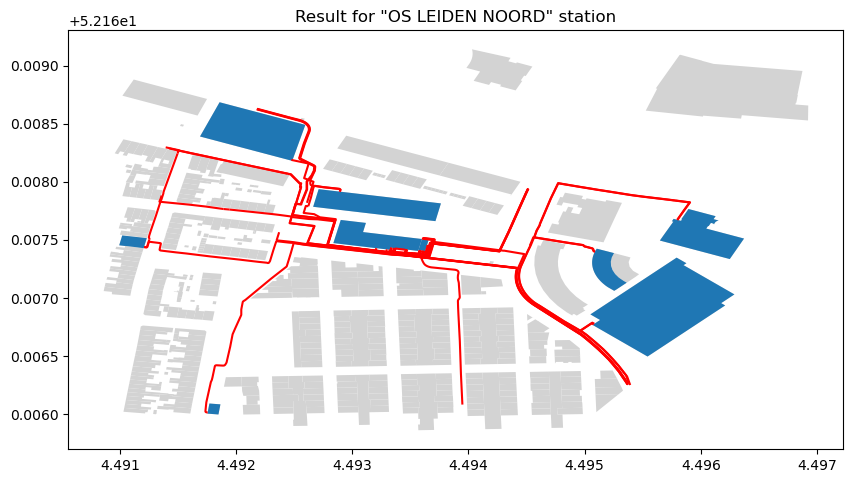

In [56]:
station_name = 'OS LEIDEN NOORD'
poi_idx = stations[stations.station == station_name].index[0]
foot_print = compiled_footprints[compiled_footprints.cluster == poi_idx]
before_foot_print = foot_prints[poi_idx]
area_of_interest = unary_union(foot_print.geometry)
minx, miny, maxx, maxy = area_of_interest.bounds
aoi_lines = ms[(ms.minx >= minx) & (ms.miny >= miny) & (ms.maxx <= maxx) & (ms.maxy <= maxy)]

size = 10
fig, ax = plt.subplots(figsize=(size, size))

ax.set_title(f'Result for "{station_name}" station')
aoi_lines.plot(ax=ax, color='red')
before_foot_print.plot(ax=ax, color='lightgrey')
foot_print.plot(ax=ax);

- Grey = footprints obtained from OSMNX
- Blue = fine-tuned by the algorithm
- Red = mid-voltage'

Next: manual fine-tuning which can be applied with ease since the rectangles return the referenced ID when selected. Thus, process is as follows -> only select the points of interest (per station), the remaining will be removed.